In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
customer_df = pd.read_csv('Customers.csv')
transaction_df = pd.read_csv('Transactions.csv')

In [3]:
customer_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [5]:
transaction_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [6]:
customer_df.isnull().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

In [7]:
transaction_df.isnull().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

In [10]:
transactions = transaction_df.groupby('CustomerID').agg(
    total_spend=('Price', 'sum'),
    transaction_count=('TransactionID', 'count')
).reset_index()


In [12]:
df= customer_df.merge(transactions, on='CustomerID', how='left').fillna(0)


In [13]:
df.head()

,CustomerID,CustomerName,Region,SignupDate,total_spend,transaction_count
0,C0001,Lawrence Carroll,South America,2022-07-10,1391.67,5.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,835.68,4.0
2,C0003,Michael Rivera,South America,2024-03-07,782.83,4.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,1925.09,8.0
4,C0005,Laura Weber,Asia,2022-08-15,874.81,3.0


In [27]:
df['SignupDate'] = pd.to_datetime(df['SignupDate'])
df['days_since_signup'] = (pd.Timestamp.now() - df['SignupDate']).dt.days

In [23]:
encoder = OneHotEncoder(sparse=False, drop='first')
region_encoded = encoder.fit_transform(df[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))

In [28]:
Df = df[['total_spend', 'transaction_count', 'days_since_signup']]
df_preprocessed = pd.concat([Df, region_encoded_df], axis=1)

In [29]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_preprocessed)

In [30]:
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    db_index = davies_bouldin_score(df_scaled, labels)
    db_scores.append(db_index)
    print(f"K={k}, DB Index={db_index}")

K=2, DB Index=1.8206473004712336
K=3, DB Index=1.3692539858936323
K=4, DB Index=1.2345954062524371
K=5, DB Index=1.145308585365165
K=6, DB Index=1.073942961076425
K=7, DB Index=1.088593853998827
K=8, DB Index=1.0881322251512755
K=9, DB Index=1.0449538512641146
K=10, DB Index=0.9873005053412497


In [31]:
optimal_k = np.argmin(db_scores) + 2
print(f"Optimal K: {optimal_k}")

Optimal K: 10


In [36]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(df_scaled)
df['Cluster'] = labels
df.head()

,CustomerID,CustomerName,Region,SignupDate,total_spend,transaction_count,days_since_signup,Cluster
0,C0001,Lawrence Carroll,South America,2022-07-10,1391.67,5.0,932,1
1,C0002,Elizabeth Lutz,Asia,2022-02-13,835.68,4.0,1079,4
2,C0003,Michael Rivera,South America,2024-03-07,782.83,4.0,326,8
3,C0004,Kathleen Rodriguez,South America,2022-10-09,1925.09,8.0,841,6
4,C0005,Laura Weber,Asia,2022-08-15,874.81,3.0,896,4


In [44]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df_scaled, clusters)
print("Silhouette Score: ", silhouette_avg)

Silhouette Score:  0.3138538268683322


In [45]:
inertia = kmeans.inertia_
print("Inertia: ", inertia)

Inertia:  712.1046006620747


In [47]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(df_scaled, clusters)
print("Calinski-Harabasz Score: ", ch_score)

Calinski-Harabasz Score:  67.48685065382854


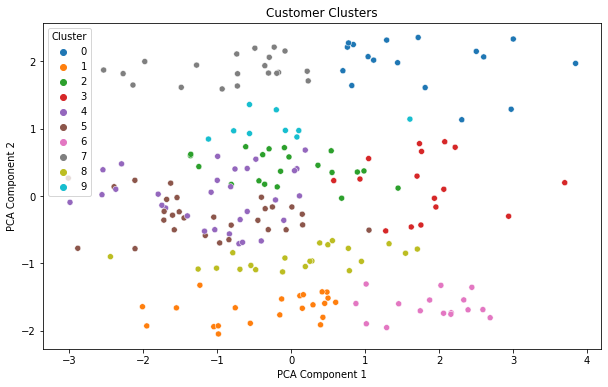

In [37]:
pca = PCA(n_components=2)
pca_df = pca.fit_transform(df_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df[:, 0], y=pca_df[:, 1], hue=df['Cluster'], palette='tab10')
plt.title('Customer Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

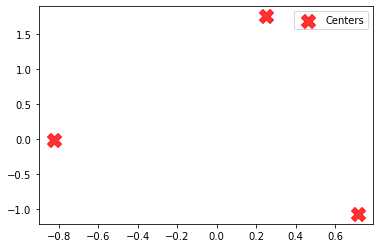

In [39]:
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.8, marker='X', label='Centers')
plt.legend()

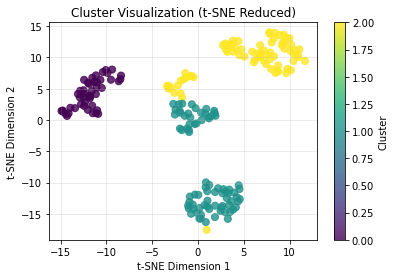

In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label="Cluster")
plt.title("Cluster Visualization (t-SNE Reduced)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.show()


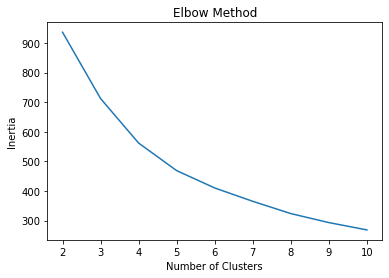

In [48]:
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()